In [1]:
%load_ext autoreload
%autoreload 2

import os 
import sys
import zipfile
import io
from pathlib import Path

SCRIPT_DIR = os.path.join(os.path.dirname(os.path.abspath('')),"wrapper")
sys.path.append(os.path.dirname(SCRIPT_DIR))

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


from wrapper.Exchange import Exchange, Asset
from wrapper.Broker import Broker
from wrapper.Strategy import Strategy
from wrapper.FastTest import FastTest, run_jit

In [22]:
file_path = "/Users/nathantormaschy/Downloads/SPY_reg.csv"

ft = FastTest(logging = True)
exchange = Exchange()
ft.register_exchange(exchange)
    
broker = Broker(exchange, margin=True, logging=True)
ft.register_broker(broker)

df = pd.read_csv(file_path, sep=",")
df["DATE"] = pd.to_datetime(pd.to_datetime(df["DATE"], format = "%Y-%m-%d"))
df.set_index("DATE",inplace=True)

new_asset = Asset(exchange, asset_name="SPY")
new_asset.set_format("%d-%d-%d", 0, 0)
new_asset.load_from_df(df, nano=True)
exchange.register_asset(new_asset)

In [23]:


class Midas_Strategy(Strategy):
    def __init__(self, broker: Broker, exchange: Exchange, lookahead) -> None:
        super().__init__(broker, exchange)
        self.lookahead = 5
        self.asset_name = "SPY"
        self.position_size = 90000
        
    def next(self):
        predicted_returns = self.exchange.get("SPY","LR_PREDS")
        
        if not self.broker.position_exists(self.asset_name):
            market_price = self.exchange.get_market_price(self.asset_name)
            units = abs(self.position_size / market_price)
            if predicted_returns < .5:
                units *= -1
            self.broker.place_market_order(self.asset_name, units, strategy_id=self.strategy_id)
            return 
        
        position = self.broker.get_position(self.asset_name)
        
        if predicted_returns < 0.5 and position.units < 0:
            return
        elif predicted_returns > 0.5 and position.units > 0:
            return
        elif predicted_returns < 0.5 and position.units > 0:
            units = -1 * position.units
            self.broker.place_market_order(self.asset_name, units, strategy_id=self.strategy_id)
            return
        elif predicted_returns > 0.5 and position.units < 0:
            units = -1 * position.units
            self.broker.place_market_order(self.asset_name, units, strategy_id=self.strategy_id)
            return

strategy = Midas_Strategy(broker, exchange, 5)

ft.build()
ft.add_strategy(strategy)
    
ft.run()

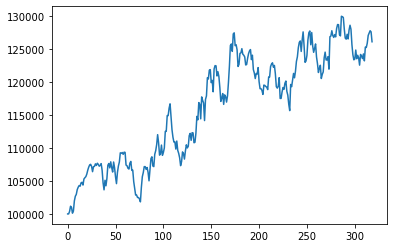

In [24]:
plt.plot(broker.get_nlv_history())